In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load the CSV file
data = pd.read_csv('data/2yrs_data.csv')

# Combine Date and Time columns into a single datetime column
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Set the new datetime column as the index
data.set_index('datetime', inplace=True)

# data.head()
# data.describe()

In [3]:
# Prediction
PREDICTION_TERM = 'Voltage'

# Graph
width = 14
height = 6

In [4]:
# Use the sum of <PREDICTION_TERM> per day

data = data[[PREDICTION_TERM]].resample('D').sum()

<Figure size 1400x600 with 0 Axes>

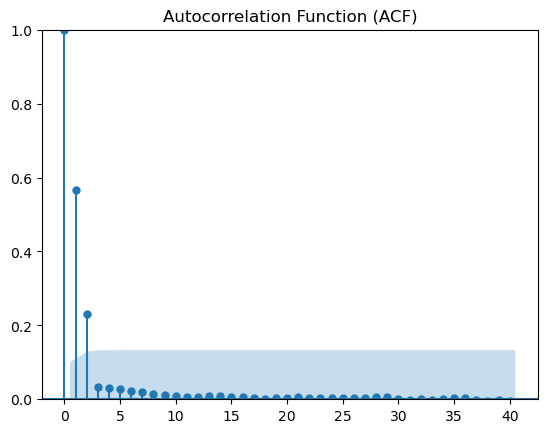

<Figure size 1400x600 with 0 Axes>

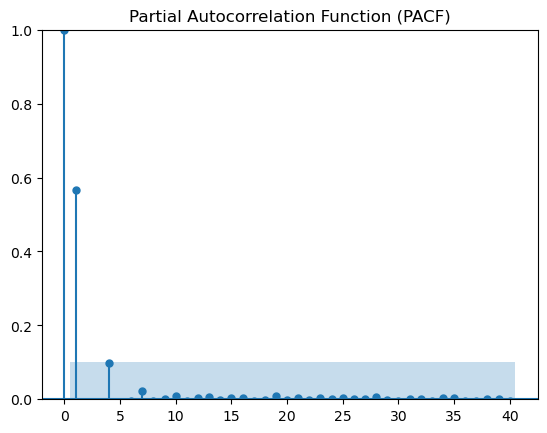

In [5]:
# Plot ACF - q
plt.figure(figsize=(width, height))
plot_acf(data[PREDICTION_TERM], lags=40)
plt.ylim(0, 1)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF - p
plt.figure(figsize=(width, height))
plot_pacf(data[PREDICTION_TERM], lags=40)
plt.ylim(0, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [6]:
# Augmented Dickey-Fuller test for stationarity
result = adfuller(data[PREDICTION_TERM])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Check Stationary
d = 1
if result[1] < 0.05:
    d = 0
    print("The process is stationary.")
else:
    print("The process is not stationary.")

ADF Statistic: -6.88376126704191
p-value: 1.4116511869036726e-09
The process is stationary.


In [7]:
# ARIMA
model = ARIMA(data[PREDICTION_TERM], order=(4, d, 3)) # p, d, q
arima_result = model.fit()

# Model Summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Voltage   No. Observations:                  381
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -4362.931
Date:                Mon, 18 Nov 2024   AIC                           8743.863
Time:                        17:12:50   BIC                           8779.348
Sample:                    12-16-2006   HQIC                          8757.942
                         - 12-31-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.417e+05   3281.796    104.121      0.000    3.35e+05    3.48e+05
ar.L1          0.9211      3.592      0.256      0.798      -6.119       7.961
ar.L2         -0.0940      0.424     -0.222      0.8

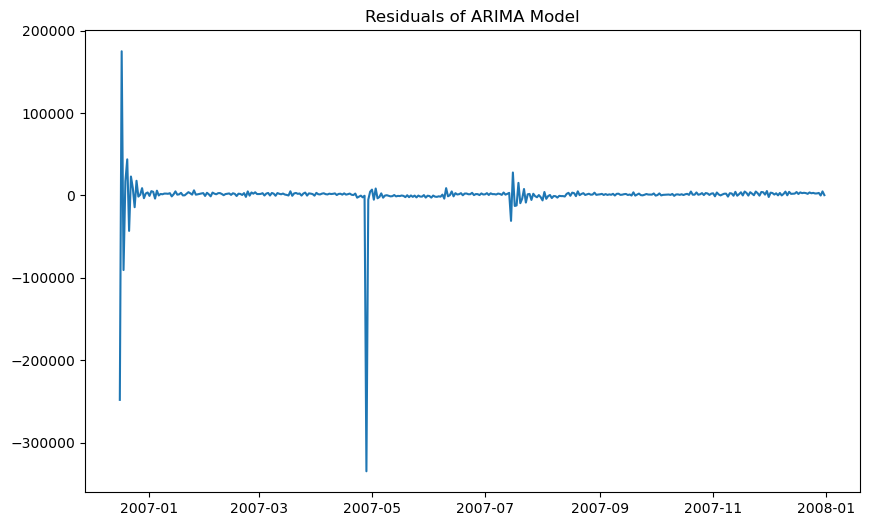

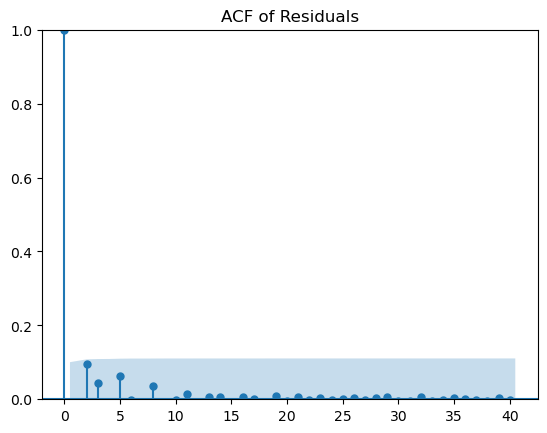

In [8]:
# Plot residuals
residuals = arima_result.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

# ACF of residuals to check if they resemble white noise
plot_acf(residuals, lags=40)
plt.ylim(0, 1)
plt.title('ACF of Residuals')
plt.show()

In [9]:
# Forecast the next 10 time periods
forecast = arima_result.forecast(steps=10)
print(forecast)

2008-01-01    345286.041527
2008-01-02    342344.402606
2008-01-03    342019.540265
2008-01-04    342040.351267
2008-01-05    341928.485034
2008-01-06    341883.878195
2008-01-07    341864.125770
2008-01-08    341841.324974
2008-01-09    341822.110489
2008-01-10    341806.382691
Freq: D, Name: predicted_mean, dtype: float64
